# Rekonstruktion af rigtigt data

I denne Notebook vil vi rekonstruere fra rigtigt CT data vha. biblioteket Core Imaging Library (CIL). 

Her er brugt et datasæt "Hyben" som eksempel. Du kan selv uploade dit eget data i mappen "EgetData/projections/" og rekonstruere det. Formentlig vil det kræve en justering af scan geometri parametrene nedenfor. 

#### Indlæs biblioteker

Her indlæser vi de Python bibliteker og funktioner vi får brug for. 

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

from cil.optimisation.algorithms import FISTA
from cil.optimisation.functions import LeastSquares, ZeroFunction
from cil.io import TIFFWriter, TIFFStackReader
from cil.framework import AcquisitionGeometry
from cil.processors import TransmissionAbsorptionConverter, Slicer
from cil.plugins.astra.processors import FBP
from cil.plugins.astra.operators import ProjectionOperator
from myplot import show2D
from cil.utilities.display import show2D

In [2]:
import astra

In [3]:
#astra.astra.set_gpu_index(1)

## CT data

I de næste sektioner vil vi indlæse vores CT data, definere scan geometrien samt visualisere dataen. 

#### CT scan geometri

Her definerer vi parametrene fra vores CT scan målesetup. 
Du kan se parametrene fra dine egne målinger i filen "settings.cto". 

In [4]:
pixel_size = 0.096            # Detektor pixel størrelse i mm
SOD = 363                     # Distance fra kilde til center af objekt i mm
SDD = 406                     # Distance fra kilde til detektor i mm
rot_axis_x = -1.0*pixel_size  # x-position af rotationsaksen
rot_axis_y = 0.0              # y-position af rotationsaksen
no_proj = 298                 # Antal projektioner
max_angle = 360               # Sidste vinkel i grader
no_det = 500                  # Antal pixels i detector, no_det x no_det
foldername = "Hyben"          # Navn på mappe med data

Nedenfor bruger vi CIL til at definere CT scan geometrien. Det er sat op således at parametrene du definerede ovenfor bliver brugt, og du behøver ikke ændre noget her. Desuden antages det, at de sidste to billeder i scanningen skal "smides væk". Det skyldes at de sidste to målinger typisk er ringe med disse maskiner. 

In [5]:
ag = AcquisitionGeometry.create_Cone3D(
    source_position=[0.0, -SOD, 0.0],
    detector_position=[0.0, SOD-SDD, 0.0],
    rotation_axis_position=[rot_axis_x, rot_axis_y, 0.0],
    rotation_axis_direction=[0.0, 0.0, 1.0])
ag.set_angles(angles=np.concatenate((np.linspace(0,max_angle,no_proj, endpoint=False), [max_angle, max_angle])), angle_unit='degree')
ag.set_panel(num_pixels=[500, 500], pixel_size=[pixel_size, pixel_size])

#### Indlæs og processer data

Først bliver datasættet indlæst, så koples det til scan geometrien og de sidste to projektioner fjernes. 

Det rå data er transmissions data $I$, der skal normaliseres og ændres til absorptions data $-\log\left(\frac{I}{I_0}\right)$ som vi kender det fra Beer-Lambert's lov. 

In [6]:
data = TIFFStackReader(file_name = foldername + "/projections/")     # load rå data
data = data.read_as_AcquisitionData(ag)                              # Tildel geometri til data 
data = Slicer(roi={'angle':(0,no_proj)})(data)                       # Skær gentaget data væk
data = data / 2.0 ** 16                                                # Normaliser data
data = TransmissionAbsorptionConverter()(data)                       # Beregn absorption -log(I/I0)

#### Visualiser data

Vi kan nu plotte og gemme en projektion fra datasættet. Du kan selv vælge projektions nr., her er projektion nr. 10 valgt. 

In [7]:
data.dimension_labels

('angle', 'vertical', 'horizontal')

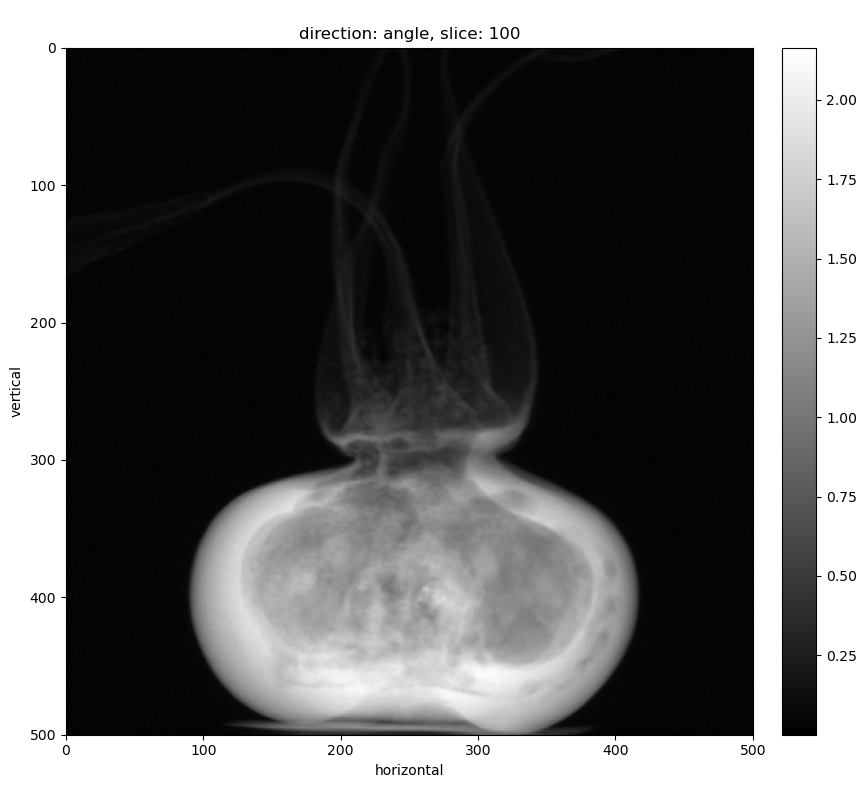

In [8]:
show2D(data, slice_list=('angle',10), origin = 'upper')

På samme måde kan vi plotte og gemme sinogrammet for en "slice" i datasættet. Du kan selv vælge slice nr., her er slice nr. 338 valgt. 

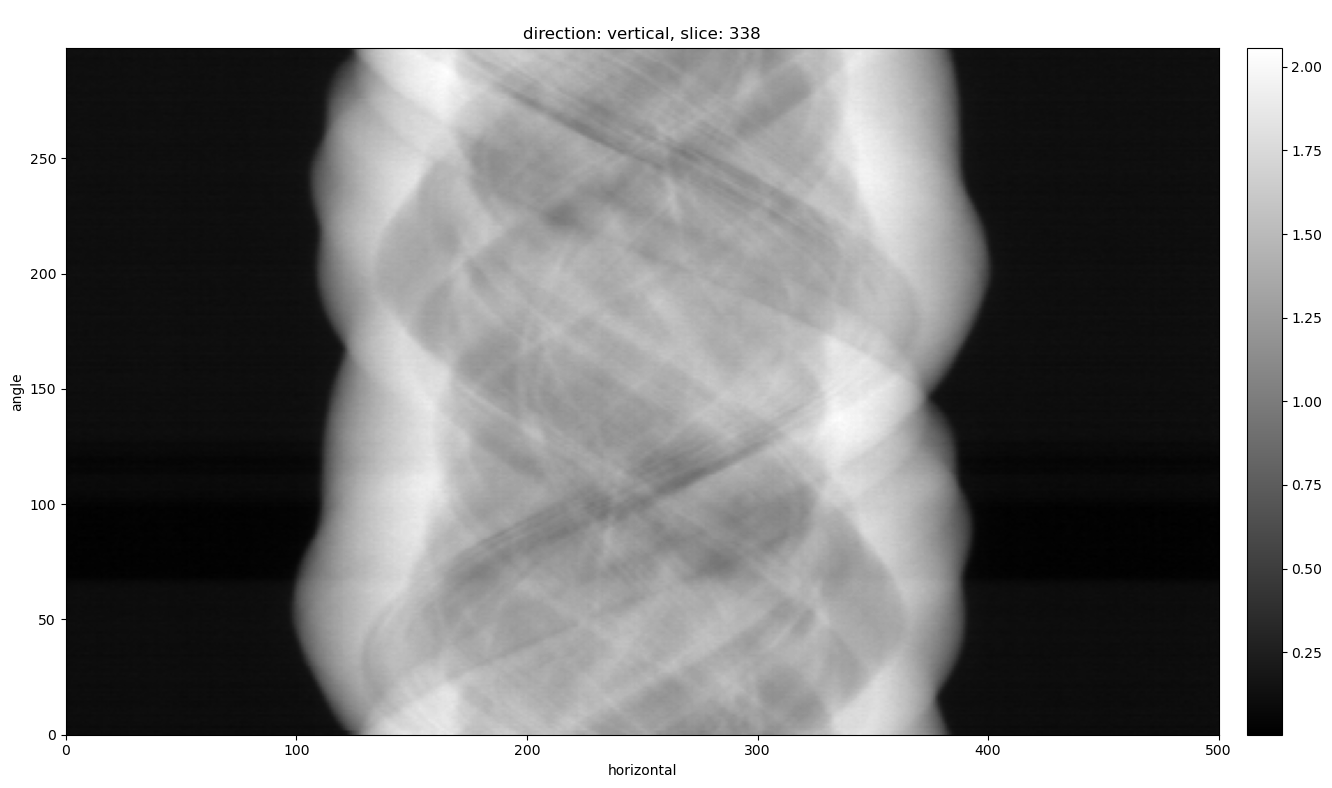

In [9]:
show2D(data, slice_list=('vertical',338))

## Rekonstruktion

Nu kan vi bruge CIL til at rekonstruere vores data. Vi benytter 2 metoder. Først filtered backprojection (FBP) og derefter en algebraisk tilgang med mindste kvadraters fit. 


#### Definer rekonstruktionens rammer

Først skal vi definere rammerne for rekonstruktionen. Bag scenen benytter CIL et biblitek der hedder ASTRA og derfor tilpasses datastrukturen til dette. Vi skal også definere *domænet* for rekonstruktionen. Altså, hvor mange pixels der er i billedet og hvilken størrelse hvert pixel har. Vi vælger at bruge CIL's default metode, der beregner det bedste rekonstruktionsdomæne baseret på den definerede scan geometri. 

In [10]:
data.reorder(order='astra')             # Brug ASTRA's datastruktur
ig = data.geometry.get_ImageGeometry()  # Definer rekonstruktions domæne

#### Filtered backprojection

Vi starter med at definere algoritmen for FBP og derefter kører vi rekonstruktionen.

In [11]:
fbp =  FBP(ig, data.geometry, "gpu") # Definer FBP algoritme
recon_fbp = fbp(data)                # Kør FBP

Vi vælger at gemme hele rekonstruktionen som tiff-filer.

In [12]:
#TIFFWriter(data=recon_fbp, file_name=foldername+"/recon/FBP/").write();

Vi kan også visualisere rekonstruktionen på samme vha. CIL. Nedenfor plottes og gemmes slice nr. 338 (svarende til sinogrammet ovenfor) og et lodret snit nr. 200. Igen kan du vælge dine egne slices ved at ændre på numrene. 

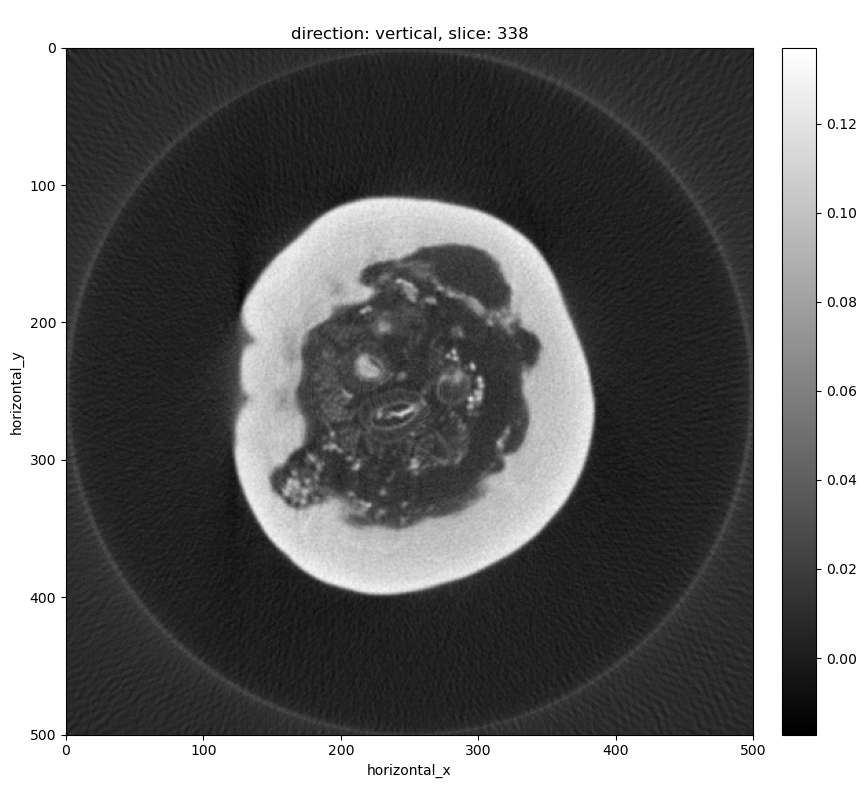

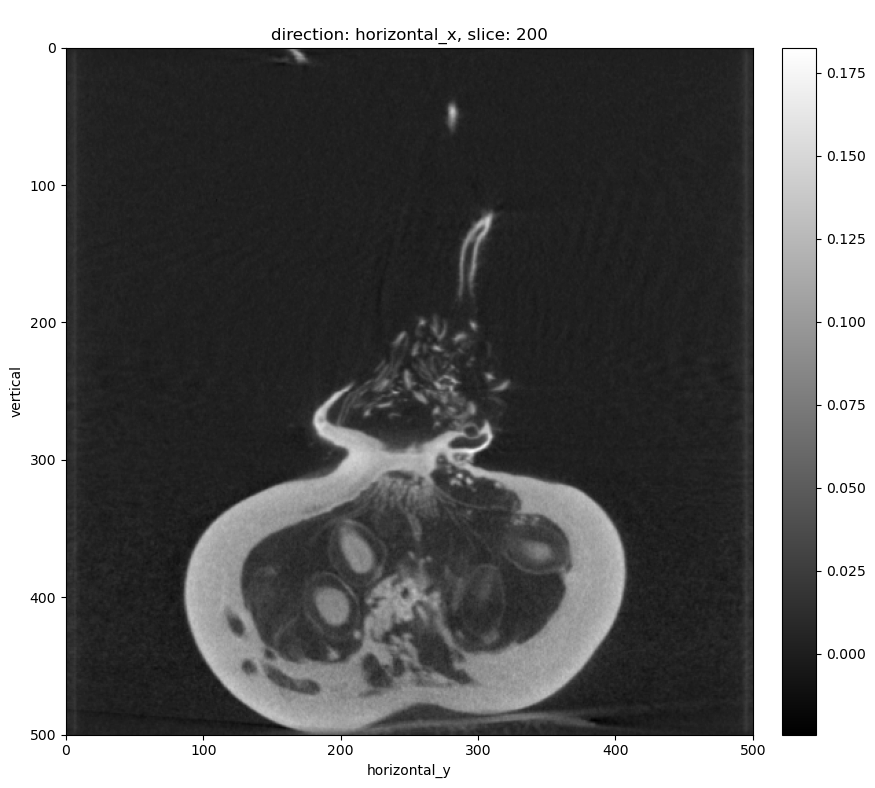

In [13]:
show2D(recon_fbp, slice_list=('vertical',338), origin = 'upper-left')

show2D(recon_fbp, slice_list=('horizontal_x', 200), origin = 'upper-left')
#plt.savefig(foldername+'/figures/recon_FBP_horizontalx_slice.png')

#### Mindste kvadraters fit

Her illustrerer vi en algebraisk metode, hvor rekonstruktionen laves som et mindste kvadraters fit (least squares, LS, på engelsk). 

Vi definerer en projektions operator $A$ som indeholder scan geometrien og rekonstruktions geometrien. Herefter defineres mindste kvadraters fit problemet i $F$. Man kan benytte en lang række algoritmer til at løse problemet, her har vi valgt en der hedder FISTA. Algoritmen defineres til sidst, dette kan tage noget tid. 

In [14]:
# Create projection operator using Astra-Toolbox.
A = ProjectionOperator(ig, data.geometry, device="gpu")
F = LeastSquares(A, data)

In [15]:
x0 = ig.allocate(0.0)

In [16]:
y0 = A.direct(x0)

In [17]:
z0 = A.adjoint(y0)

In [18]:
x0 = ig.allocate(0.0)
LS = FISTA(f=F, g=ZeroFunction(),
            initial=x0, 
            max_iteration=1000, 
            update_objective_interval=1)

Når problemet og løsningsalgoritmen er defineret (ovenfor), kan vi køre algoritmen. Vi kører 50 iterationer, du kan evt. eksperimentere med antal. 

Bemærk, hvis du kører LS.run(50) to gange i træk, gemmes outputtet fra første run og anden gang itereres videre. Dvs. output fra andet run svarer til 100 iterationer. 

In [19]:
LS.run(5, verbose=True)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          3.77895e+07
        1       1000         1.694          5.32494e+06
        2       1000         1.702          3.61660e+06
        3       1000         1.704          2.35619e+06
        4       1000         1.721          1.52170e+06
        5       1000         1.738          1.01230e+06
-------------------------------------------------------
        5       1000         1.738          1.01230e+06
Stop criterion has been reached.



Igen kan vi gemme rekonstruktionen i tiff-filer og/eller visualisere vha. CIL:

In [20]:
#TIFFWriter(data=recon_fbp, file_name=foldername+"/recon/LS/").write();

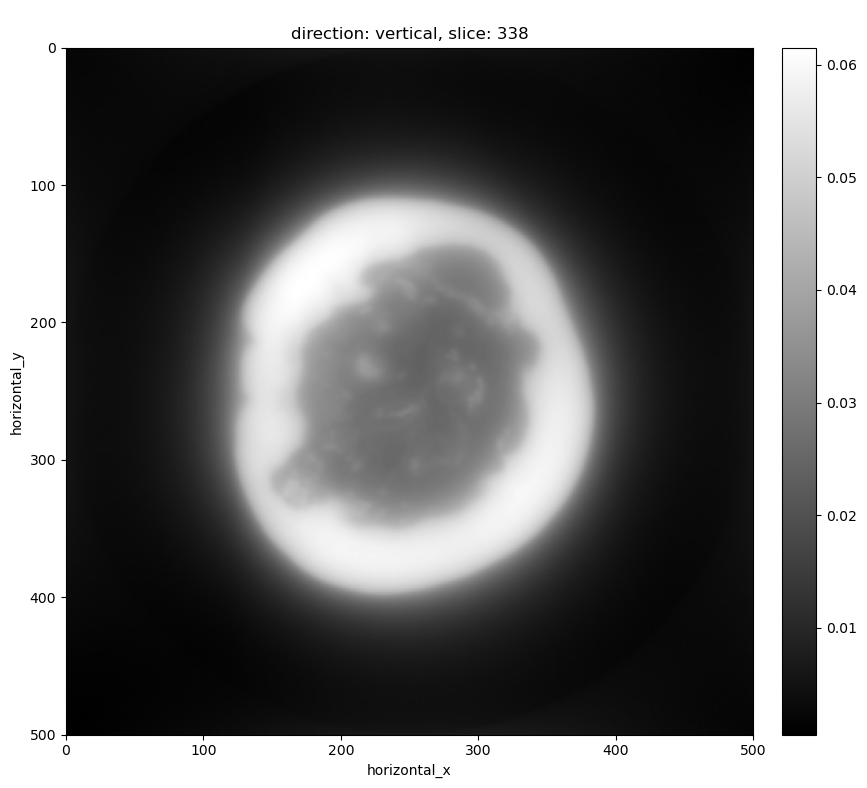

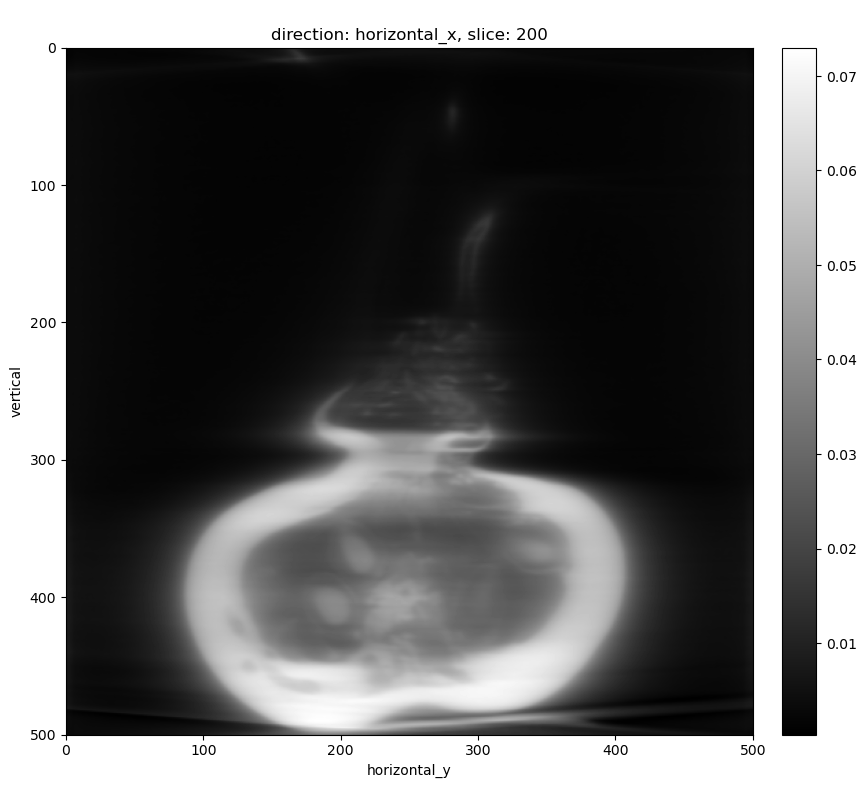

In [21]:
show2D(LS.solution, slice_list=('vertical',338), origin = 'upper-left')

show2D(LS.solution, slice_list=('horizontal_x', 200), origin = 'upper-left')

# Tillykke! Du har nu lavet dine egne rekonstruktioner.